### Imports

In [1]:
from keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from keras.datasets import fashion_mnist # Import the mnist dataset
from keras.layers import Input, Dense # Layers to be used for building our model
from keras.models import Model # The class used to create a model
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils # Utilities to manipulate numpy arrays
from tensorflow import set_random_seed # Used for reproducible experiments

import gc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


### Data manipulation

**Task**: Given an image of handwritten digit find the digit

**Data**:
- The data are grayscale 28*28 images of fashion items
- We will use an MLP to classify them so we first need to flatten them
- The values of the inputs are in [0, 255] so we normalize them to [0, 1]

In [3]:
batch_size = 128
classes = 10
epochs = 100

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, classes)
Y_test = np_utils.to_categorical(y_test, classes)

### Plotting results

In [4]:
def plot_history(hs, epochs, metric):
    plt.clf()
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 16
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric))
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric))
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


### Cleaning up

In [5]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


### Model creation

- We will use a Functional Model.
    - It is more flexible than the `Sequential` model but ...
    - We need to be careful with the sizes of the layers.
- The first layer should always be an `Input` layer where we specify the input of the model, e.g., the training data
- The other layers can be whatever we want and for each layer we must:
    - Define the input to the layer, i.e., another layer.
    - Define the number of units which also defines the output size.
        - The output size must be always equal to the number of units of the next layer.


In [6]:
def train_model(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128,
        hidden_layers=0,
        hidden_activation='relu',
        output_activation='softmax'):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_random_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
        x = Dense(
            units=256,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    # Define the output layer.
    output = Dense(
        units=classes,
        kernel_initializer='uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=0,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs


### Using SGD

In [7]:
# Using SGD
optimizer = SGD(lr=0.01)

# Logistic Regression
lr_model_sgd, lr_hs_sgd = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
lr_eval_sgd = lr_model_sgd.evaluate(X_test, Y_test, verbose=1)
clean_up(model=lr_model_sgd)

Finished training.
------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 33us/step


### Logistic Regression results

Train Loss     : 0.41825
Validation Loss: 0.42424
Test Loss      : 0.45847
---
Train Accuracy     : 0.85796
Validation Accuracy: 0.85333
Test Accuracy      : 0.84010


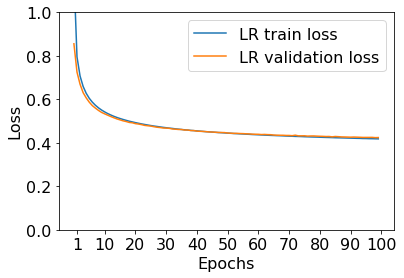

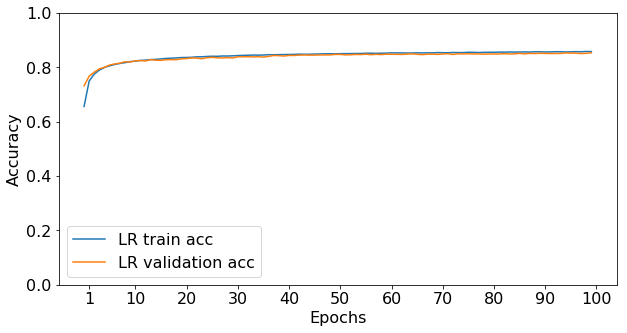

In [8]:
print("Train Loss     : {0:.5f}".format(lr_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(lr_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(lr_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(lr_hs_sgd.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(lr_hs_sgd.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(lr_eval_sgd[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='acc')

In [9]:
# Using SGD
optimizer = SGD(lr=0.01)

# MLP
mlp_model_sgd, mlp_hs_sgd = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_sgd = mlp_model_sgd.evaluate(X_test, Y_test, verbose=1)
clean_up(model=mlp_model_sgd)

Finished training.
------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Output (Dense)               (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 47us/step


### Logistic Regression vs. MLP results

Train Loss     : 0.30401
Validation Loss: 0.34127
Test Loss      : 0.36661
---
Train Accuracy     : 0.89422
Validation Accuracy: 0.87767
Test Accuracy      : 0.86890


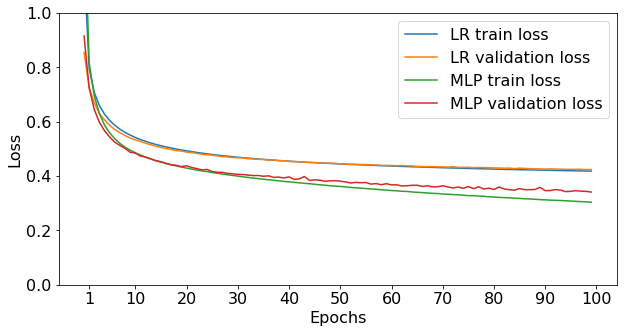

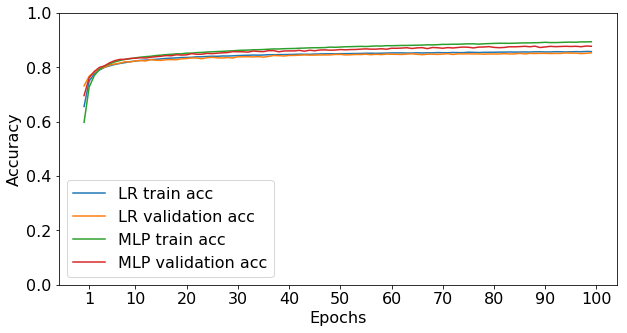

In [10]:
print("Train Loss     : {0:.5f}".format(mlp_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_sgd.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_sgd.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_sgd[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_sgd, 'MLP': mlp_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_sgd, 'MLP': mlp_hs_sgd}, epochs=epochs, metric='acc')

### Using Adam

In [11]:
# Using Adam
optimizer = Adam()

# Logistic Regression
lr_model_adam, lr_hs_adam = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
lr_eval_adam = lr_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=lr_model_adam)

Finished training.
------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 25us/step


### Logistic Regression results

Train Loss     : 0.34821
Validation Loss: 0.41511
Test Loss      : 0.45332
---
Train Accuracy     : 0.87757
Validation Accuracy: 0.85600
Test Accuracy      : 0.84450


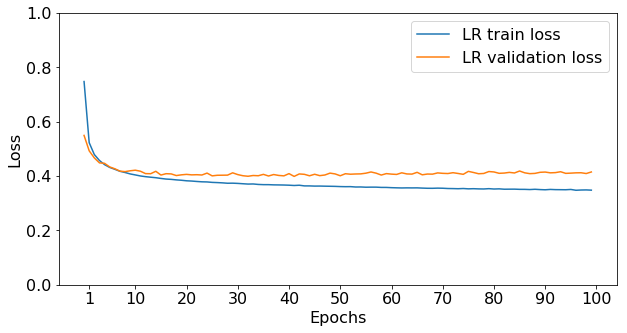

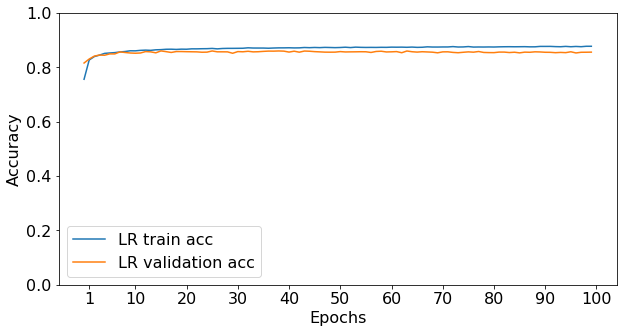

In [12]:
print("Train Loss     : {0:.5f}".format(lr_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(lr_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(lr_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(lr_hs_adam.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(lr_hs_adam.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(lr_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_adam}, epochs=epochs, metric='acc')

In [13]:
# Using Adam
optimizer = Adam()

# MLP
mlp_model_adam, mlp_hs_adam = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_adam = mlp_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=mlp_model_adam)

Finished training.
------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 784)               0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Output (Dense)               (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 49us/step


### Logistic Regression vs. MLP results

Train Loss     : 0.03551
Validation Loss: 0.62081
Test Loss      : 0.64026
---
Train Accuracy     : 0.98678
Validation Accuracy: 0.89367
Test Accuracy      : 0.89420


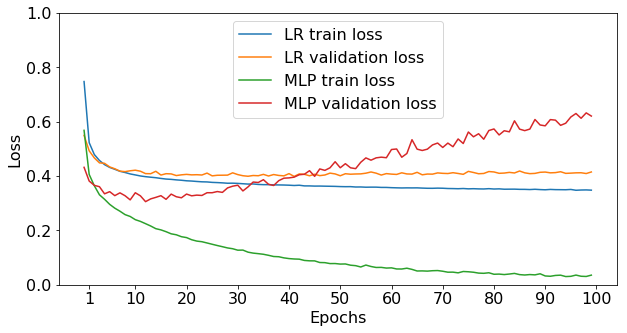

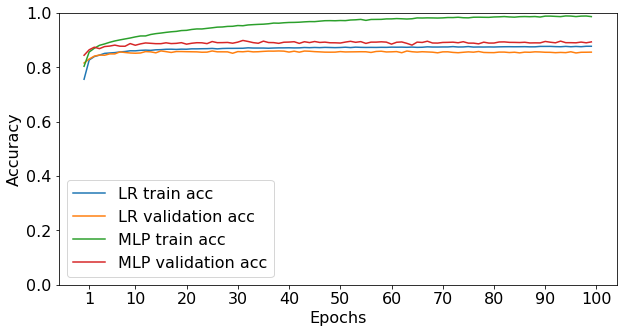

In [14]:
print("Train Loss     : {0:.5f}".format(mlp_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_adam.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_adam.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_adam, 'MLP': mlp_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_adam, 'MLP': mlp_hs_adam}, epochs=epochs, metric='acc')

In [13]:
exit()